In [ ]:
import os
import numpy as np
import tensorflow
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from PIL import Image
import os

def resize_images_from_train(base_input_dir, base_output_dir, target_size=(256, 256), total_images=6208, split_ratio=5600/6208):
    train_dir = os.path.join(base_input_dir, 'train')

    train_sat_out = os.path.join(base_output_dir, 'train_resize/satellite_resize')
    train_mask_out = os.path.join(base_output_dir, 'train_resize/mask_resize')
    val_sat_out = os.path.join(base_output_dir, 'validation_resize/validation_satellite_resize')
    val_mask_out = os.path.join(base_output_dir, 'validation_resize/validation_mask_resize')

    for path in [train_sat_out, train_mask_out, val_sat_out, val_mask_out]:
        os.makedirs(path, exist_ok=True)

    sat_images = sorted([f for f in os.listdir(train_dir) if f.endswith('_sat.jpg')])[:total_images]

    train_count = int(split_ratio * total_images)

    for idx, filename in enumerate(sat_images):
        img_path = os.path.join(train_dir, filename)
        mask_filename = filename.replace('_sat.jpg', '_mask.png')
        mask_path = os.path.join(train_dir, mask_filename)

        img = Image.open(img_path).resize(target_size, Image.Resampling.LANCZOS)
        mask = Image.open(mask_path).resize(target_size, Image.Resampling.LANCZOS)

        if idx < train_count:
            img.save(os.path.join(train_sat_out, filename))
            mask.save(os.path.join(train_mask_out, mask_filename))
        else:
            img.save(os.path.join(val_sat_out, filename))
            mask.save(os.path.join(val_mask_out, mask_filename))


In [ ]:
resize_images_from_train(
    base_input_dir='/content/drive/MyDrive/deepglobe_dataset',
    base_output_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized',
    total_images=6208
)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir=None, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)

        if mask_dir:
            self.mask_filenames = os.listdir(mask_dir)
            assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must match."
        else:
            self.mask_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('DataGenerator object is out of range')
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.target_size, 3))  # Satellite images with 3 channels (RGB)
        if self.mask_dir:
            y = np.empty((self.batch_size, *self.target_size, 1))  # Masks converted to 1 channel
        else:
            y = None

        for i, image_name in enumerate(batch_images):
            # Load and preprocess satellite image (RGB)
            img_path = os.path.join(self.image_dir, image_name)
            image = load_img(img_path, target_size=self.target_size)  # Default is RGB
            X[i,] = img_to_array(image) / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask image (convert RGB to grayscale)
            if self.mask_dir:
                mask_name = image_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')  # Load mask as grayscale
                y[i,] = img_to_array(mask) / 255.0

        return X, y

In [ ]:
train_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/train_resize/satellite_resize',
    mask_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/train_resize/mask_resize',
    batch_size=32,
    target_size=(256, 256),
    shuffle=True
)

val_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/validation_resize/validation_satellite_resize',
    mask_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/validation_resize/validation_mask_resize',
    batch_size=32,
    target_size=(256, 256),
    shuffle=False
)


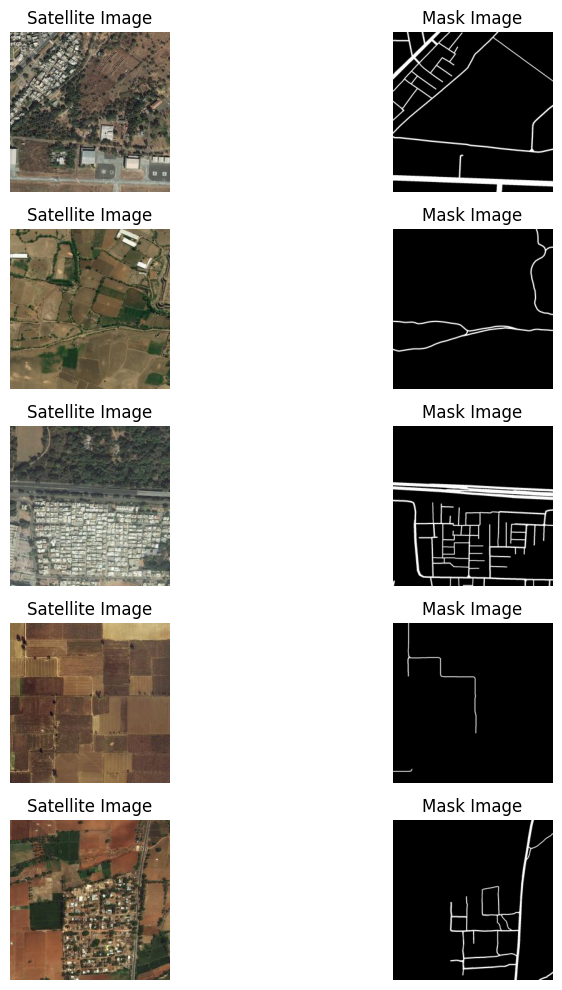

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = train_gen[0]  # Get first bactch

num_images = 5

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i, 0].imshow(satellite_images[i])
    axes[i, 0].set_title('Satellite Image')
    axes[i, 0].axis('off')

    # Display mask image
    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove single-dimensional entries
    axes[i, 1].set_title('Mask Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(train_gen)
print(f"Total batches in train_gen: {total_batches}")

Total batches in train_gen: 175


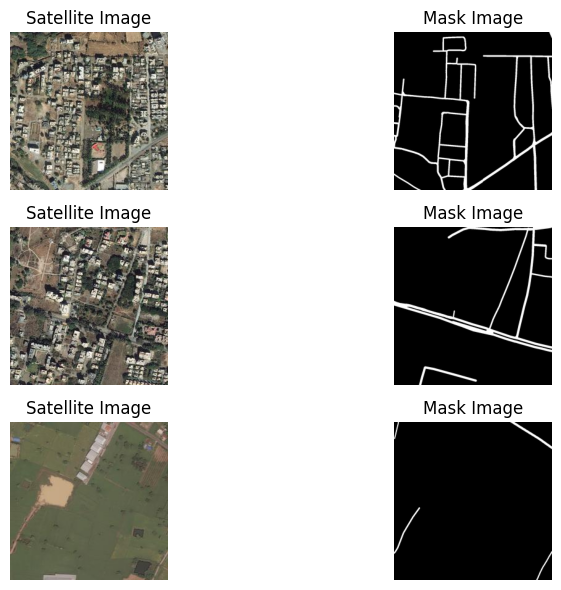

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = val_gen[0]  # Get the first batch

num_images = 3

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    axes[i, 0].imshow(satellite_images[i])
    axes[i, 0].set_title('Satellite Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove single-dimensional entries
    axes[i, 1].set_title('Mask Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(val_gen)
print(f"Total batches in val_gen: {total_batches}")

Total batches in val_gen: 19


In [ ]:
import os
import shutil
import random

def create_test_dataset(source_image_dir, dest_image_dir, num_images=100):
    """
    Creates a test dataset by randomly selecting images from the train dataset.
    Only copies satellite images, excluding masks.

    Args:
        source_image_dir: Path to the source directory containing training images.
        dest_image_dir: Path to the destination directory for test images.
        num_images: Number of images to select for the test dataset.
    """
    # Create destination directory if it doesn't exist
    os.makedirs(dest_image_dir, exist_ok=True)

    # Get a list of image filenames from the source directory
    image_filenames = os.listdir(source_image_dir)

    # Randomly select a subset of images
    selected_images = random.sample(image_filenames, num_images)

    # Copy selected images to the destination directory
    for image_filename in selected_images:
        source_image_path = os.path.join(source_image_dir, image_filename)
        dest_image_path = os.path.join(dest_image_dir, image_filename)
        shutil.copy(source_image_path, dest_image_path)

# Example usage:
source_image_dir = '/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/train_resize/satellite_resize'
dest_image_dir = '/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/test_resize/images'

create_test_dataset(source_image_dir, dest_image_dir, num_images=100)

In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/deepglobe_dataset/updated-data-resized/test_resize/images',  # Specify the 'images' subdirectory
    batch_size=32,  # Or adjust the batch size
    target_size=(256, 256),
    shuffle=False
)

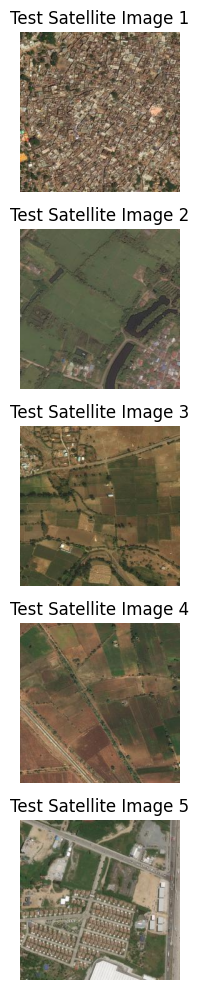

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_gen yields (images, masks), you can access the images like this:
test_images, _ = test_gen[0]  # Ignore masks for visualization

num_images = 5

fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i].imshow(test_images[i])  # Access the individual image
    axes[i].set_title(f'Test Satellite Image {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:

def binary_unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3): # Changed function name
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1) # 128*128*16

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2) # 64*64*32

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3) # 32*32*64

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4) # 16*16*128

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5) # at this point it 16*16*256
    # no more max pooling and downsampling to 8*8 as we may loose critical spatial information

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4]) # 128+128 features = 256 feature maps at u6 now
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3]) # 64+64 features = 128 feature maps at u7 now
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2]) # 32+32 features = 64 feature maps at u8 now
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3) # 16+16 features = 32 feature maps at u9 now
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)


    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
model = binary_unet_model(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint callback with the specified path
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    validation_data=val_gen,
    validation_steps=10,
    epochs=8,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9198 - loss: 0.2074 
Epoch 1: val_loss improved from inf to 0.17328, saving model to /content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1228s 25s/step - accuracy: 0.9198 - loss: 0.2073 - val_accuracy: 0.9152 - val_loss: 0.1733
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9119 - loss: 0.1750 
Epoch 2: val_loss improved from 0.17328 to 0.17035, saving model to /content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1208s 24s/step - accuracy: 0.9119 - loss: 0.1749 - val_accuracy: 0.9152 - val_loss: 0.1703
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9127 - loss: 0.1653 
Epoch 3: val_loss improved from 0.17035 to 0.15899, saving model to /content/drive/MyDrive/road-extraction-DL/updated-data-resized/best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 1199s 24s/step - accuracy: 0.9127 - loss: 0.1

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss did not improve from 0.15899
50/50 ━━━━━━━━━━━━━━━━━━━━ 682s 13s/step - accuracy: 0.9169 - loss: 0.1545 - val_accuracy: 0.9152 - val_loss: 0.1727
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9131 - loss: 0.1585 
Epoch 5: val_loss did not improve from 0.15899
50/50 ━━━━━━━━━━━━━━━━━━━━ 1221s 24s/step - accuracy: 0.9131 - loss: 0.1584 - val_accuracy: 0.9152 - val_loss: 0.1867
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9134 - loss: 0.1532 
Epoch 6: val_loss did not improve from 0.15899
50/50 ━━━━━━━━━━━━━━━━━━━━ 1190s 24s/step - accuracy: 0.9134 - loss: 0.1532 - val_accuracy: 0.9152 - val_loss: 0.1737
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9104 - loss: 0.1546 
Epoch 7: val_loss did not improve from 0.15899
50/50 ━━━━━━━━━━━━━━━━━━━━ 1223s 25s/step - accuracy: 0.9104 - loss: 0.1546 - val_accuracy: 0.9152 - val_loss: 0.1596
Epoch 8/8
25/50 ━━━━━━━━━━━━━━━━━━━━ 9:26 23s/step - accuracy: 0.9106 - loss: 0.1484
Epo

In [ ]:
model.save('/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/best_model(full).keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/best_model(full).keras')

In [ ]:
#### FOR TEST GEN ONLY ####
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir=None, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)

        if mask_dir:
            self.mask_filenames = os.listdir(mask_dir)
            assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must match."
        else:
            self.mask_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('DataGenerator object is out of range')
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.target_size, 3))  # Satellite images with 3 channels (RGB)

        # Initialize y even if mask_dir is None
        y = np.empty((self.batch_size, *self.target_size, 1))

        for i, image_name in enumerate(batch_images):
            # Load and preprocess satellite image (RGB)
            img_path = os.path.join(self.image_dir, image_name)
            image = load_img(img_path, target_size=self.target_size)  # Default is RGB
            X[i,] = img_to_array(image) / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask image (convert RGB to grayscale)
            if self.mask_dir:
                mask_name = image_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')  # Load mask as grayscale
                y[i,] = img_to_array(mask) / 255.0
            #else:
                # You can fill y with dummy data if needed
                #y[i,] = np.zeros((*self.target_size, 1))  # Example: Fill with zeros


        return X, y

In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/test_resize/images',
    mask_dir=None,  # Masks are not needed for testing
    batch_size=1,
    target_size=(256, 256),
    shuffle=False
)

In [ ]:
predictions = model.predict(test_gen)

100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step


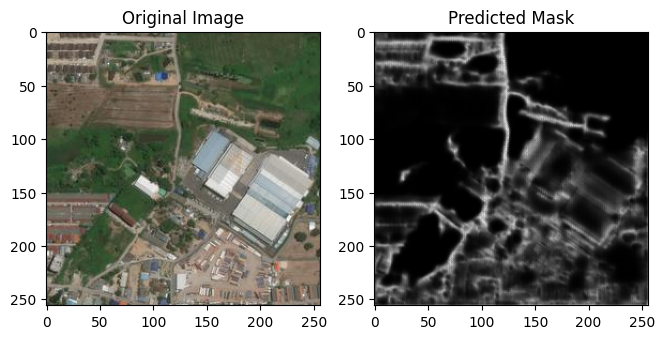

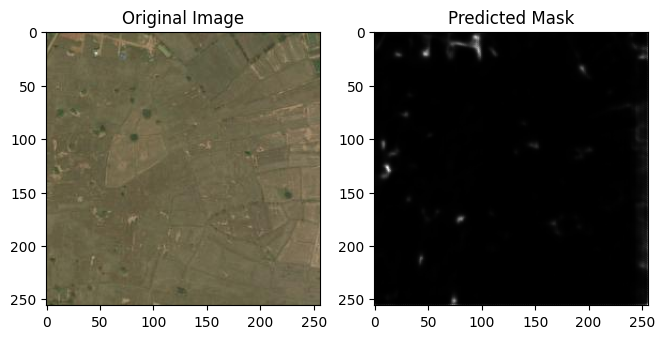

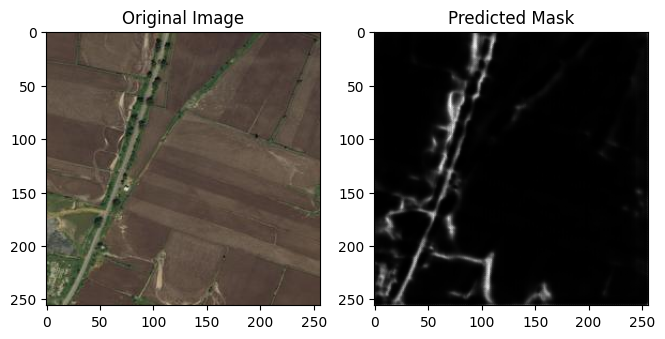

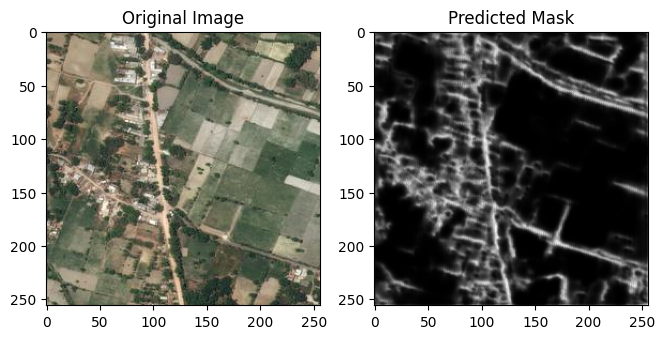

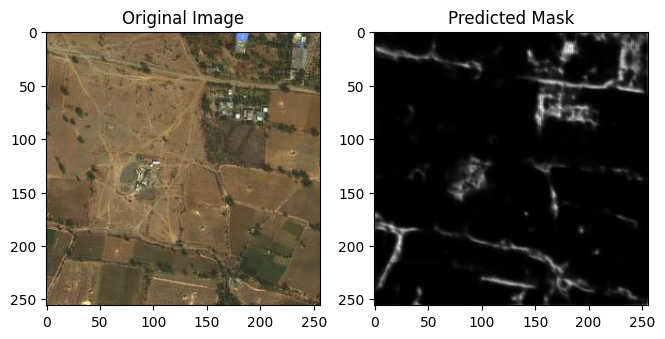

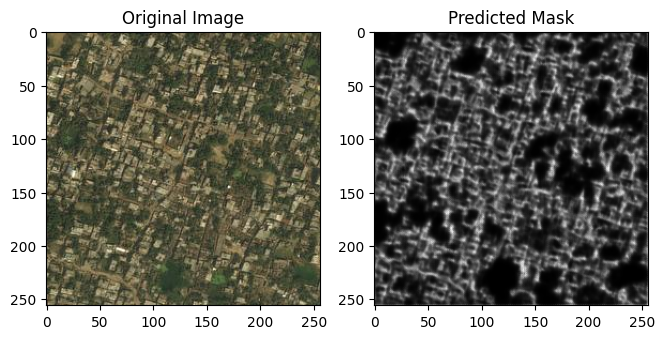

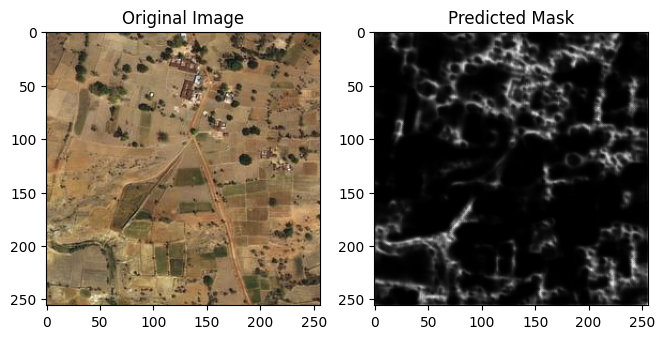

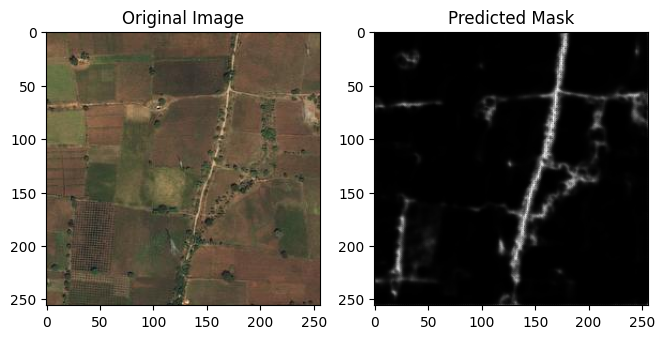

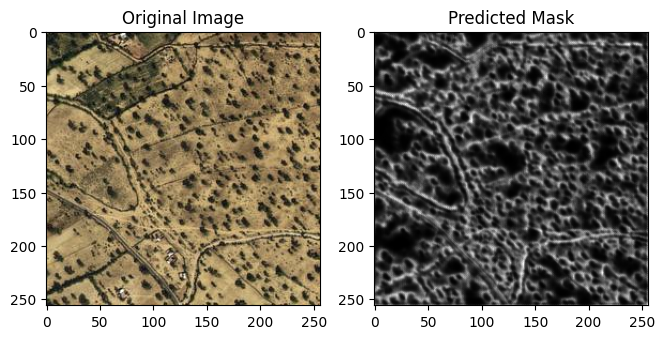

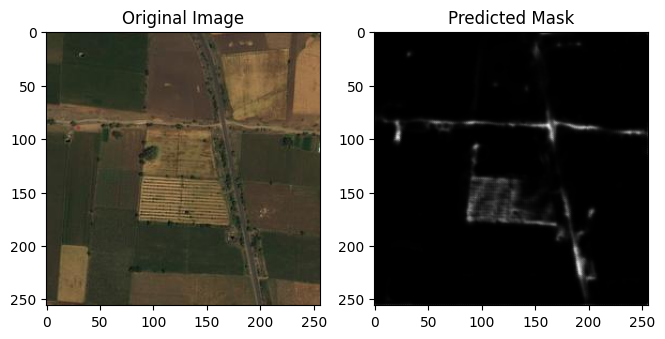

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some predictions
num_images_to_show = 10  # Adjust as needed

for i in range(num_images_to_show):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_gen[i][0][0])  # Get the first test image
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove channels if needed
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
#### Testing on random images ######
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to your resized test images
test_images_path = '/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/test_resize/images'

# Get a list of all image filenames
image_filenames = os.listdir(test_images_path)

# Randomly select a subset of images for testing
num_samples = 5  # Specify the number of images to test
sample_filenames = random.sample(image_filenames, num_samples)

# Load and preprocess images
test_images = []
for filename in sample_filenames:
    image_path = os.path.join(test_images_path, filename)
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Resize to match model input
    image_array = np.array(image) / 255.0  # Normalize pixel values
    test_images.append(image_array)

test_images = np.array(test_images)


In [ ]:
from tensorflow.keras.models import load_model

# Load your trained U-Net model
model = load_model('/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/best_model(full).keras', compile=False)

# Predict segmentation masks for the test images
predicted_masks = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Threshold the predicted masks to obtain binary masks
binary_masks = (predicted_masks > 0.15).astype(np.uint8)

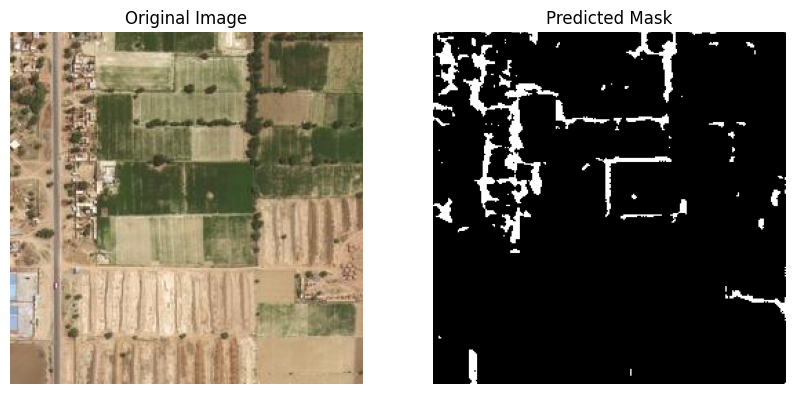

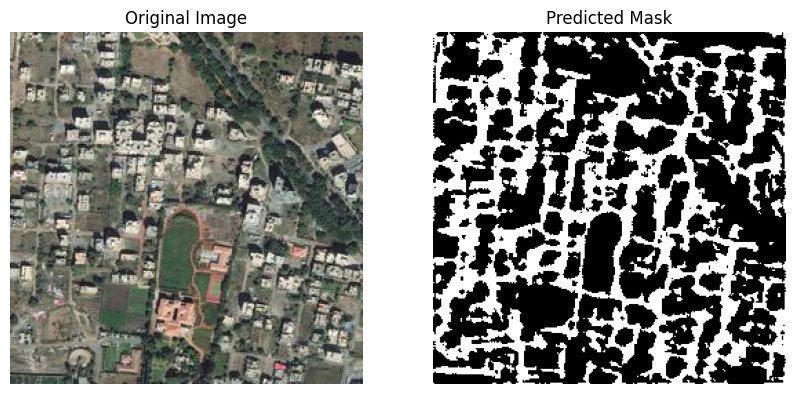

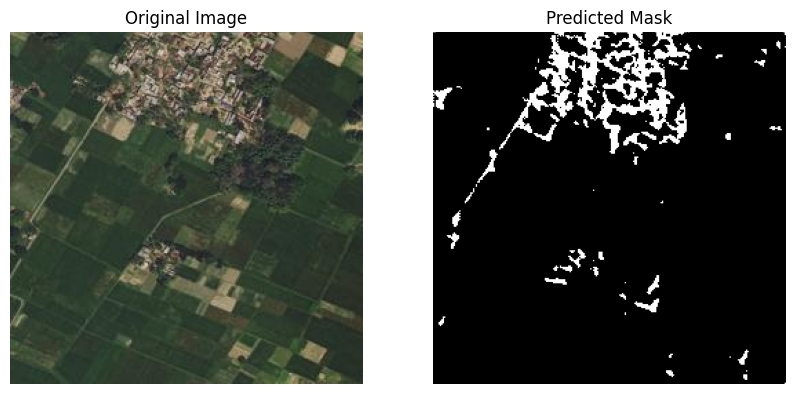

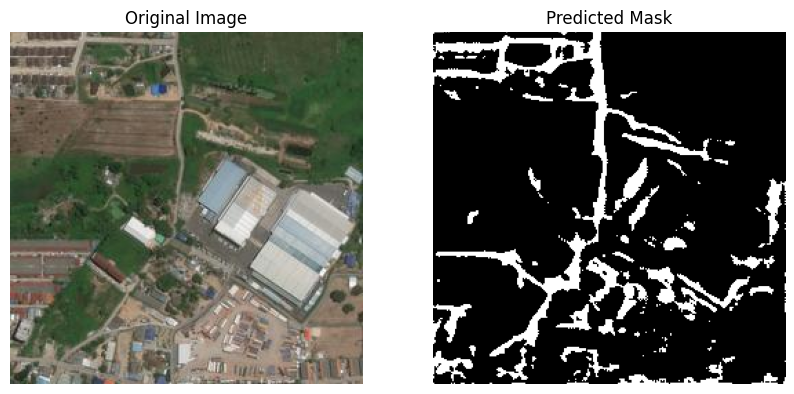

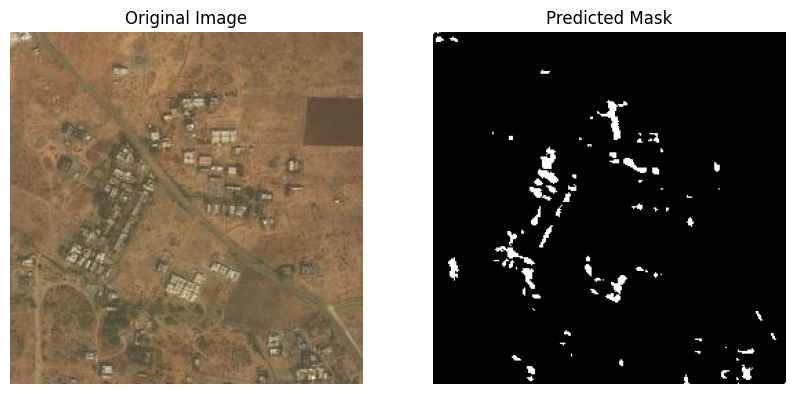

In [ ]:
# Visualize the original images and their corresponding predicted masks
for i in range(num_samples):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(binary_masks[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


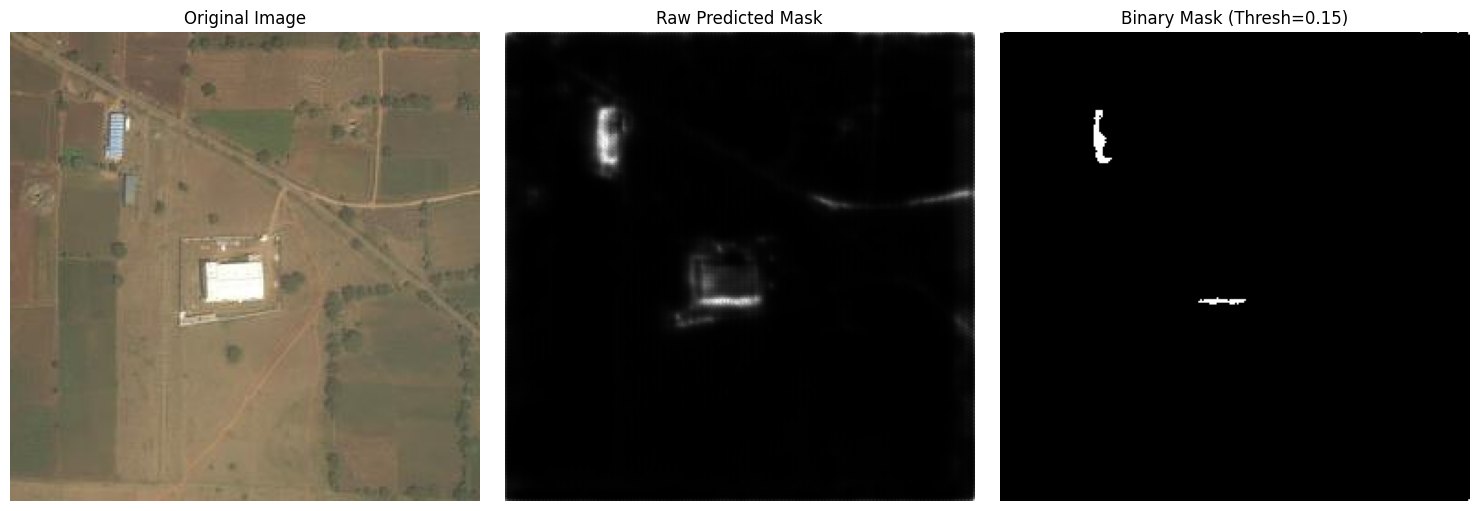

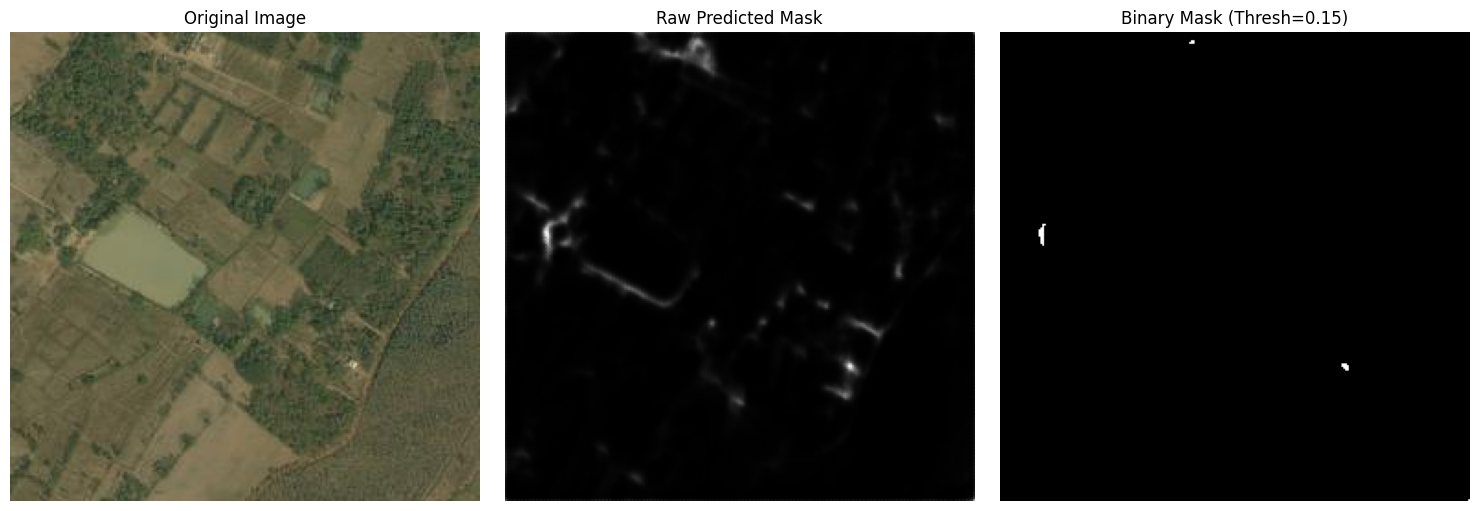

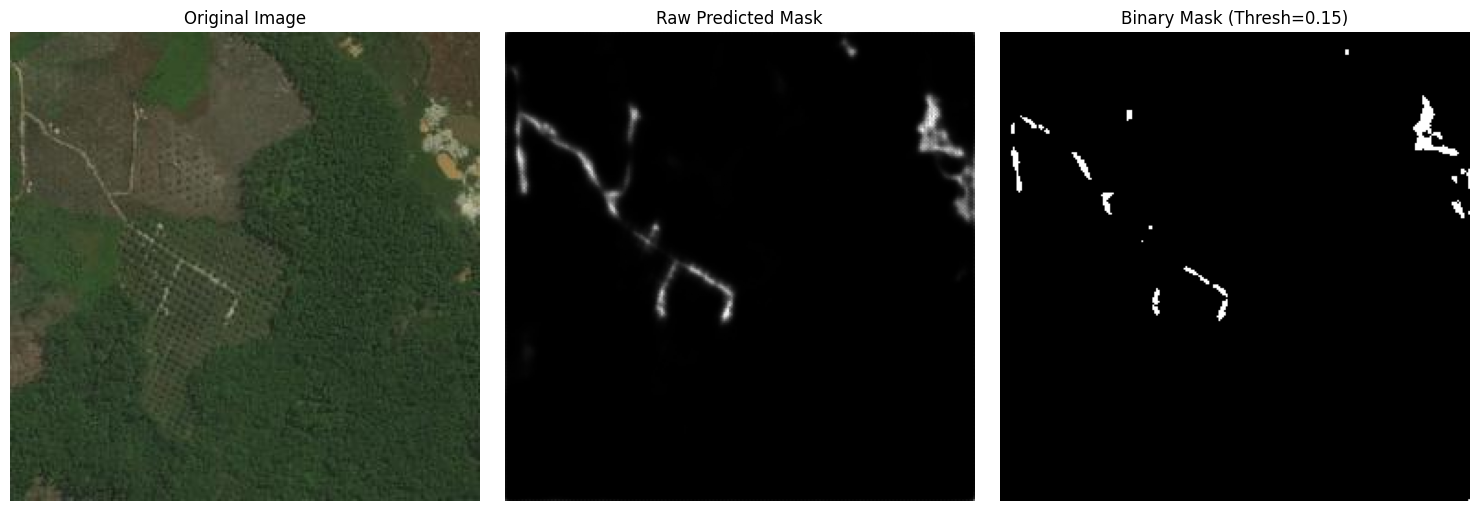

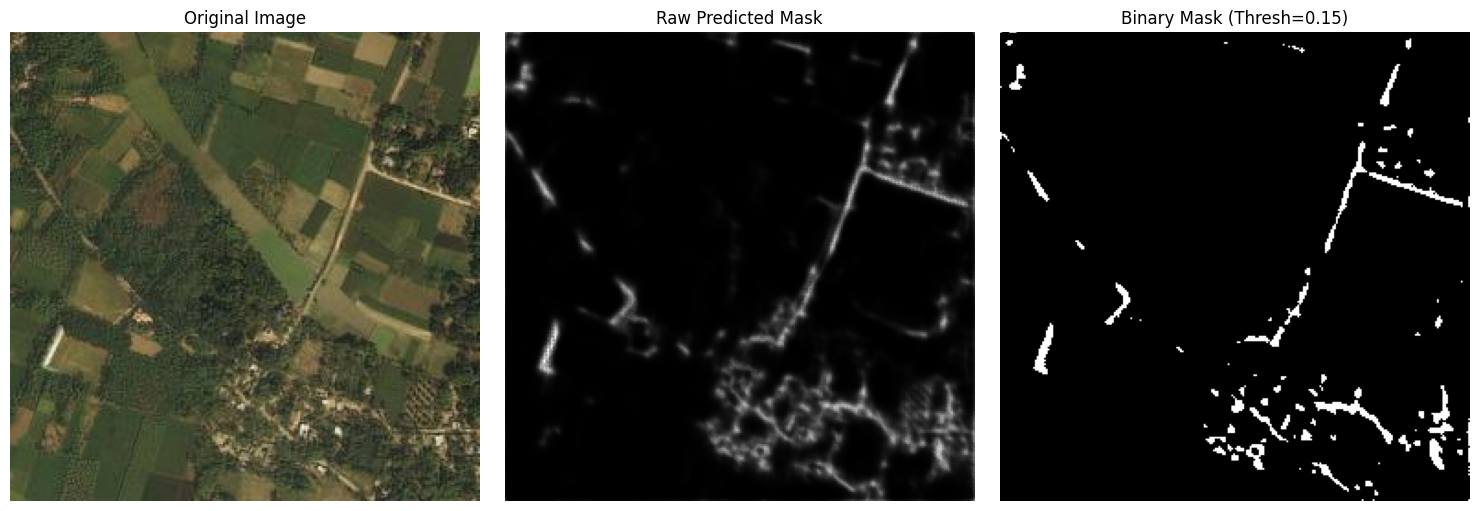

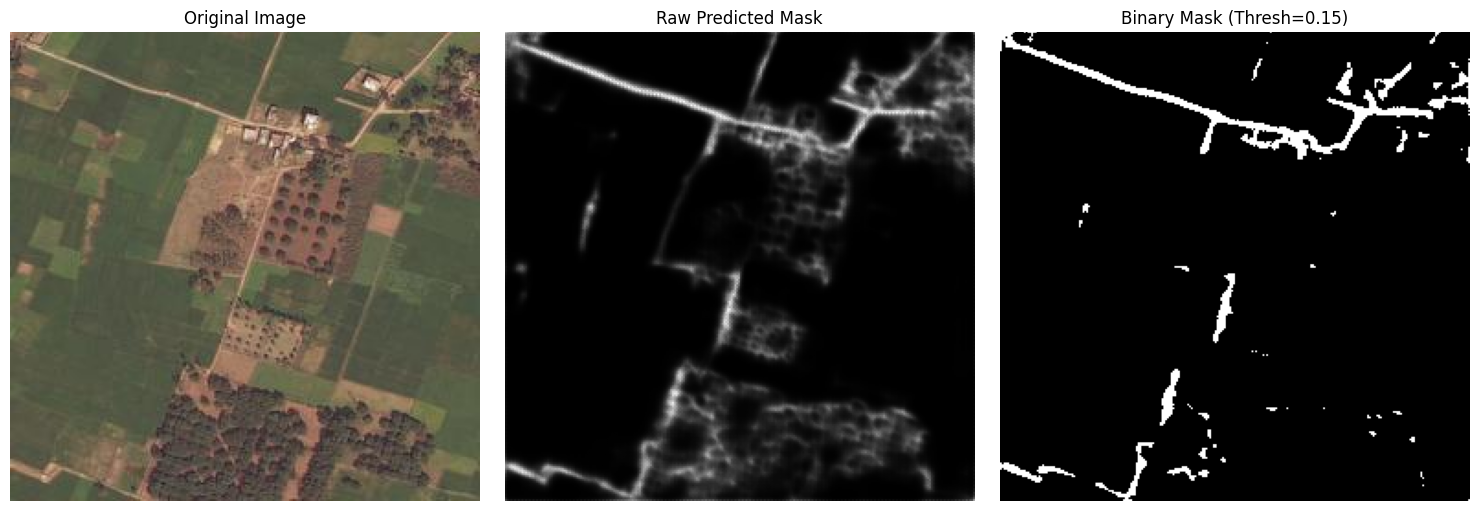

In [ ]:
#### Testing and predicting ####
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# === Settings ===
test_images_path = '/content/drive/MyDrive/deepglobe_dataset/full/updated-data-resized/test_resize/images'
num_images_to_show = 5  # Adjust as needed
threshold = 0.15        # Prediction threshold

# === Load and preprocess random test images ===
image_filenames = [f for f in os.listdir(test_images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
sample_filenames = random.sample(image_filenames, num_images_to_show)

test_images = []
original_images = []

for filename in sample_filenames:
    image_path = os.path.join(test_images_path, filename)
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))                    # Match model input
    original_images.append(np.array(image))             # Save for later display
    image_array = np.array(image) / 255.0               # Normalize
    test_images.append(image_array)

test_images = np.array(test_images)                     # Shape: (N, 256, 256, 3)

# === Make predictions ===
predicted_masks = model.predict(test_images)
binary_masks = (predicted_masks > threshold).astype(np.uint8)

# === Visualize predictions ===
for i in range(num_images_to_show):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_images[i])
    plt.title('Original Image')
    plt.axis('off')

    # Raw Predicted Mask (heatmap)
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title('Raw Predicted Mask')
    plt.axis('off')

    # Thresholded Binary Mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_masks[i].squeeze(), cmap='gray')
    plt.title(f'Binary Mask (Thresh={threshold})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
history_dict = {
    'accuracy': [0.9198, 0.9119, 0.9127, 0.9169, 0.9131, 0.9134, 0.9104, 0.9107],
    'val_accuracy': [0.9152, 0.9152, 0.9152, 0.9152, 0.9152, 0.9152, 0.9152, 0.9152],
    'loss': [0.2073, 0.1749, 0.1653, 0.1545, 0.1584, 0.1532, 0.1546, 0.1488],
    'val_loss': [0.1733, 0.1703, 0.1590, 0.1727, 0.1867, 0.1737, 0.1596, 0.1533]
}

In [ ]:
import matplotlib.pyplot as plt

def plot_saved_history(history_dict, model_name='Model'):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


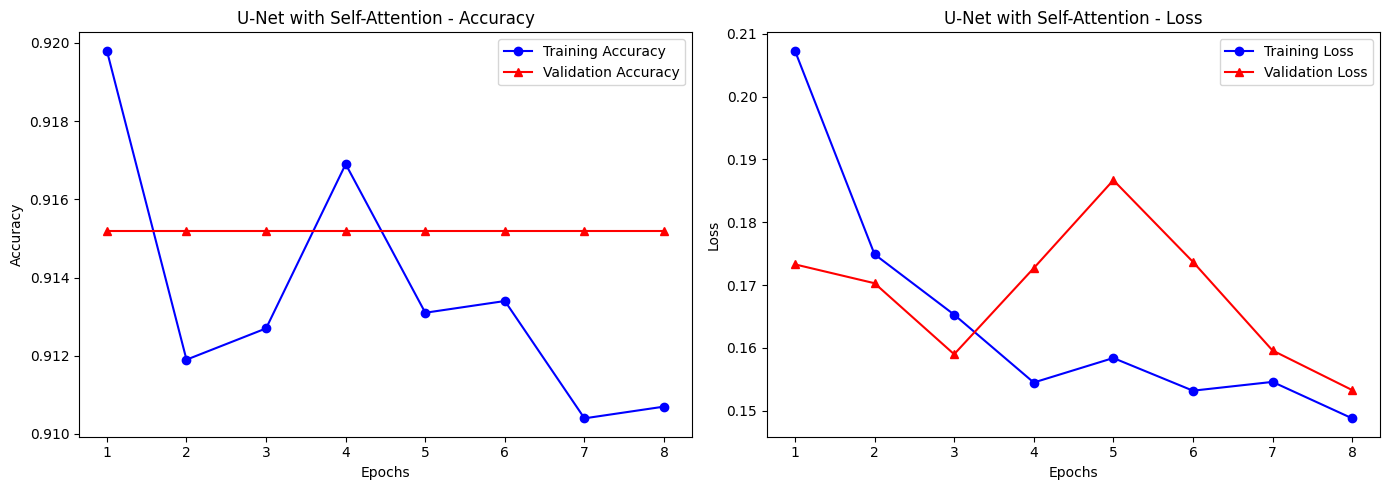

In [ ]:
plot_saved_history(history_dict, model_name='U-Net')